In [1]:
# Activa figuras interactivas
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt
import pandas as pd
import time
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel, DotProduct
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime

<IPython.core.display.Javascript object>


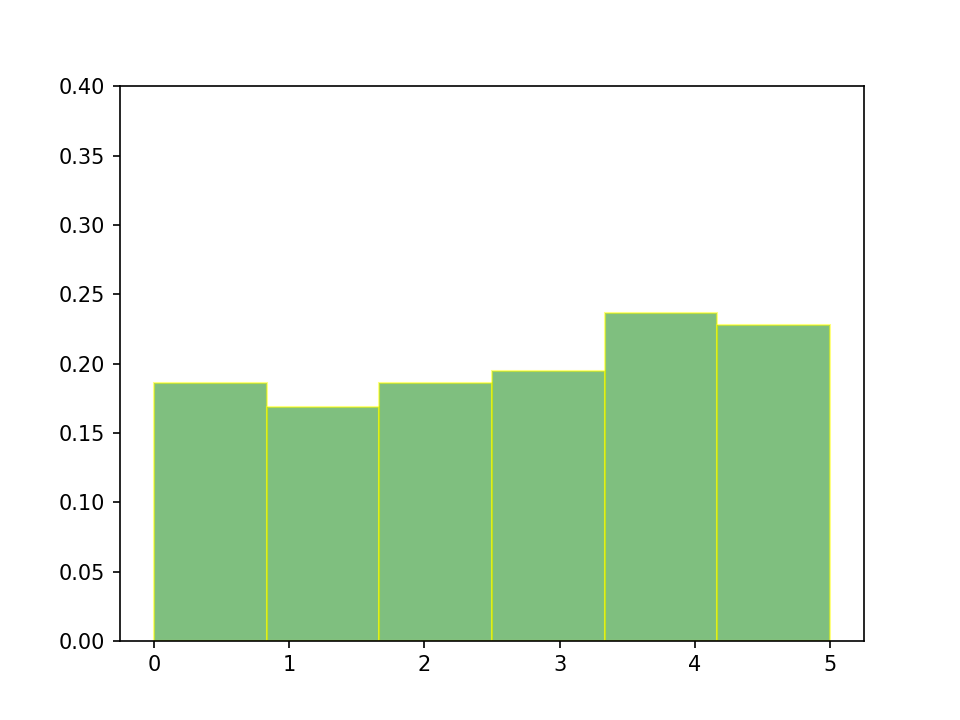

In [2]:


amount = 1000
number_of_frames = amount
data = np.asarray([np.random.randint(0, 6) for i in range(amount)])
nbins = 6

def update_hist_dice(num, data):
    ax.cla()
    ax.set(ylim=(0, 0.4))
    ax.hist(data[0:num],bins=nbins,density=True, lw=1, ec="yellow", fc="green", alpha=0.5)


fig, ax = plt.subplots()
ax.set(ylim=(0, 0.4))
ax.hist(data[0],bins=nbins,density=True, lw=1, ec="yellow", fc="green", alpha=0.5)




animation = FuncAnimation(fig, update_hist_dice, frames=number_of_frames,interval=50, fargs=(data, ) )
plt.show()

<IPython.core.display.Javascript object>


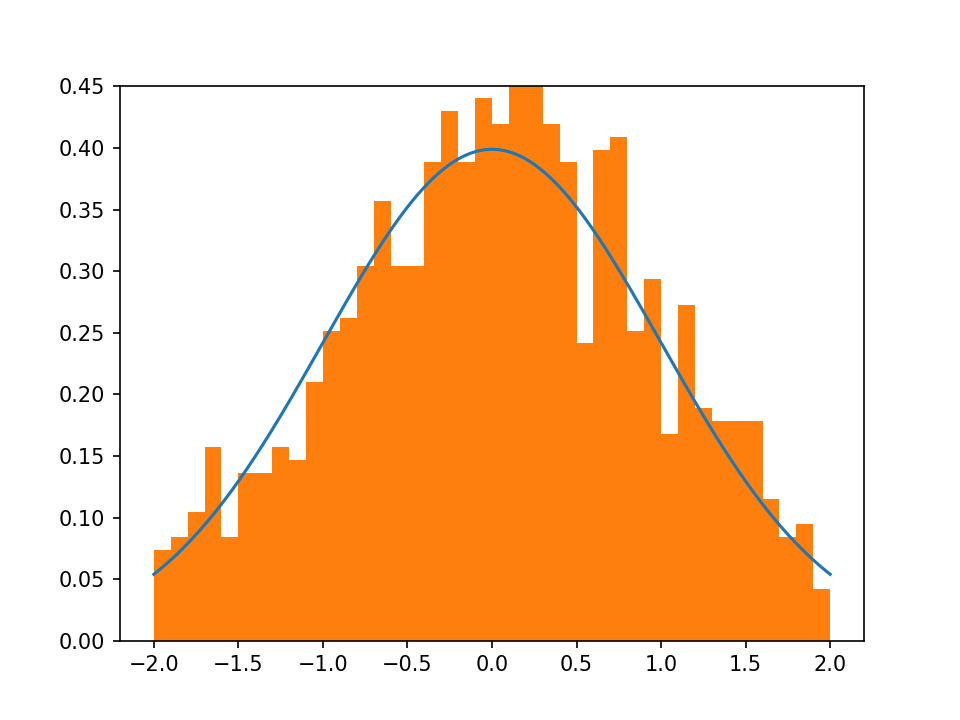

In [3]:

def update_hist_gaus(num, data2):
    ax.cla()
    ax.set(ylim=(0, 0.45))
    ax.plot(x,y)
    ax.hist(data2[0:num],range=(-2.,2.),bins=nbins,density=True)
    

amount2 = 100000
number_of_frames = amount2
data2 = [np.random.normal(0, 1) for i in range(amount)]
nbins = 40

x = np.linspace(-2.,2.,1000)
y = (1./np.sqrt(2.*np.pi))*np.exp(-np.power(x,2)/2.)


fig, ax = plt.subplots()
ax.set(ylim=(0, 0.45))
ax.hist(data2[0],range=(-2,2),bins=nbins,density=True)
ax.plot(x,y)




animation2 = FuncAnimation(fig, update_hist_gaus, frames=number_of_frames,interval=1, fargs=(data2, ) )
plt.show()

### $F = m g \sin\left(\theta\right) +\eta\left(t\right)$

In [175]:
def euler(y, tf, h, a, g, r):
    t = np.linspace(0, tf, int(tf/h+1)) # Numerical grid
    # Explicit Euler Method
    s = np.zeros((2,len(t)))
    
    s[:,0] = y
    for i in range(0, len(t) - 1):
        ruido = r*np.random.normal(0,np.sqrt(h))
        
        theta, omega = s[:,i]
        
        dydt = np.asarray([omega + ruido/h, -a*omega - g*np.sin(theta)])
        s[:,i + 1] = s[:,i] + h*dydt
        
        
    return s


<IPython.core.display.Javascript object>


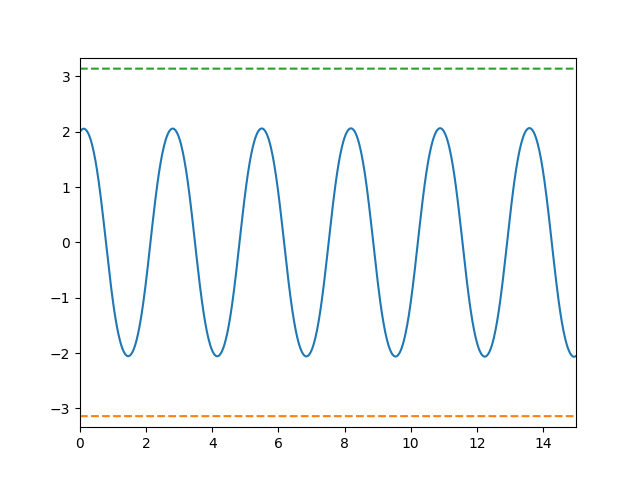

In [277]:

a = 0.00
g = 10.0
r = 0.0

endt= 15

y0 = [2., 1.]
tf = endt
h = 0.0001
t = np.linspace(0,tf,int(tf/h+1))

sol = euler(y0, tf, h, a, g, r)

# Re muestreamos la solucion para la visualización
nr = int(len(sol[0,:])/(tf*60))
solr = sol[:,0:-1:nr]
tr =       t[0:-1:nr]

fig = plt.figure()
ax = plt.axes(xlim=(0, endt), ylim=(-np.pi-0.2, np.pi+0.2))
line, = ax.plot([], [],)
ax.plot(t,-np.ones(len(t))*(np.pi),'--')
ax.plot(t,np.ones(len(t))*(np.pi),'--')



#plt.plot(t,sol[:,1])


def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(tr[:i], solr[0,:i])
    return line,

anim = FuncAnimation(fig, animate, frames=len(t), interval=60, blit=True)



### Aplicamos GP

In [151]:
## Dividimos el dataset en entrenamiento y validacion

# entrenamiento 10 segundos (66% del dataset)
nt = int(len(sol[0,:])*0.66)
total = len(sol[0,:])
y_train = sol[0,0:nt:400][:,np.newaxis]
t_train =   t[0:nt:400][:,np.newaxis]
# validacion 5 segundos (33% del dataset)
y_test = sol[0,nt::400][:,np.newaxis]
t_test =   t[nt::400][:,np.newaxis]

gp = GaussianProcessRegressor(kernel=1.*RBF(length_scale=1.)+WhiteKernel(noise_level=1.), alpha=0, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=10)

gp.fit(t_train,y_train)


y_pred, y_std = gp.predict(t[:,np.newaxis], return_std=True)

/usr/local/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


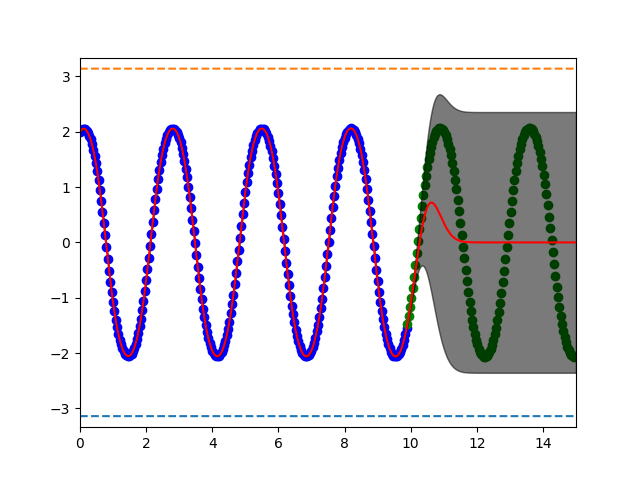

Los hiperparámetros son :  1.3893309375080565 0.4456445966721865 0.003162277660168379


In [152]:

fig = plt.figure()
ax = plt.axes(xlim=(0, endt), ylim=(-np.pi-0.2, np.pi+0.2))

ax.plot(t,-np.ones(len(t))*(np.pi),'--')
ax.plot(t,np.ones(len(t))*(np.pi),'--')

ax.scatter(t_train[:,0],y_train[:,0],color='b', label = 'Observaciones para condicionar GP')
ax.scatter(t_test[:,0],y_test[:,0], color='g',label = 'Observaciones a predecir')
ax.plot(t, y_pred[:,0], color='r', label ='Valor promedio de la regresión')
#ax_2_1.plot(muestreo_continuo,signal_continua,color='orange',label=r"Señal sin ruido; y(t) = $A*sin(\omega*x)$ + p*x + b + $r*\eta(t)_{wh}$")
ax.fill_between(t, y_pred[:,0] - 2.*y_std, y_pred[:,0] + 2.*y_std, alpha=0.2, color='k',label = 'Banda incertidumbre 1 $\sigma$')
ax.fill_between(t, y_pred[:,0] - 2.*y_std, y_pred[:,0] + 2.*y_std, alpha=0.4, color='k',label = 'Banda incertidumbre 1 $\sigma$')
plt.show()

print('Los hiperparámetros son : ', np.exp(gp.kernel_.theta[0]),np.exp(gp.kernel_.theta[1]),np.sqrt(np.exp(gp.kernel_.theta[2])))


In [153]:
## Dividimos el dataset en entrenamiento y validacion

# entrenamiento 10 segundos (66% del dataset)
nt = int(len(sol[0,:])*0.66)
total = len(sol[0,:])
y_train = sol[0,0:nt:400][:,np.newaxis]
t_train =   t[0:nt:400][:,np.newaxis]
# validacion 5 segundos (33% del dataset)
y_test = sol[0,nt::400][:,np.newaxis]
t_test =   t[nt::400][:,np.newaxis]

gp = GaussianProcessRegressor(kernel=1.*ExpSineSquared(length_scale=1.,periodicity=1.)+WhiteKernel(noise_level=1.), alpha=0, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=10)

gp.fit(t_train,y_train)


y_pred, y_std = gp.predict(t[:,np.newaxis], return_std=True)

/usr/local/lib64/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


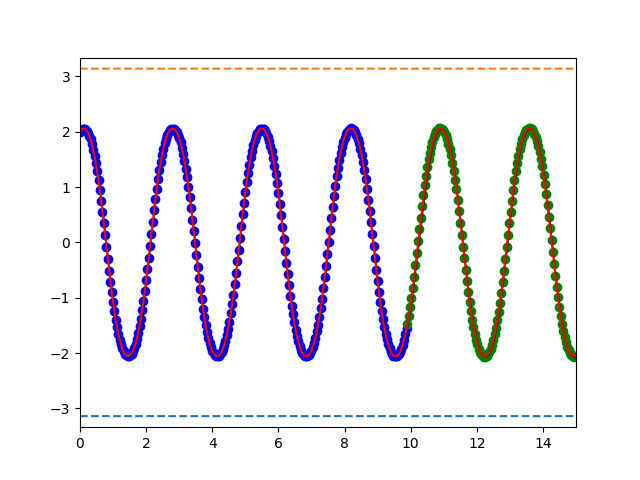

Los hiperparámetros son :  1.5375101346698545 0.27752243171878727 3.434268354341011 0.003162277660168379


In [154]:

fig = plt.figure()
ax = plt.axes(xlim=(0, endt), ylim=(-np.pi-0.2, np.pi+0.2))

ax.plot(t,-np.ones(len(t))*(np.pi),'--')
ax.plot(t,np.ones(len(t))*(np.pi),'--')

ax.scatter(t_train[:,0],y_train[:,0],color='b', label = 'Observaciones para condicionar GP')
ax.scatter(t_test[:,0],y_test[:,0], color='g',label = 'Observaciones a predecir')
ax.plot(t, y_pred[:,0], color='r', label ='Valor promedio de la regresión')
#ax_2_1.plot(muestreo_continuo,signal_continua,color='orange',label=r"Señal sin ruido; y(t) = $A*sin(\omega*x)$ + p*x + b + $r*\eta(t)_{wh}$")
ax.fill_between(t, y_pred[:,0] - 2.*y_std, y_pred[:,0] + 2.*y_std, alpha=0.2, color='k',label = 'Banda incertidumbre 1 $\sigma$')
ax.fill_between(t, y_pred[:,0] - 2.*y_std, y_pred[:,0] + 2.*y_std, alpha=0.4, color='k',label = 'Banda incertidumbre 1 $\sigma$')
plt.show()

print('Los hiperparámetros son : ', np.exp(gp.kernel_.theta[0]),np.exp(gp.kernel_.theta[1]),np.exp(gp.kernel_.theta[2])/np.pi,np.sqrt(np.exp(gp.kernel_.theta[3])))
